In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

from tools_fast import *
from clustering import cluster, cluster_net
from hc_graph import hc_stock, hc_piechart, hc_spiderweb

<IPython.core.display.Javascript object>

Open console to check js libs were loaded in page


In [8]:
fund_name = 'CARMPAT'
pd.read_csv(r"financial_data/hfrx_index_names.csv", index_col=0)

,Full Name
Name,
HFRXAR,HFRX Absolute Return Index
HFRXDS,HFRX ED: Distressed Restructuring Index
HFRXMA,HFRX ED: Merger Arbitrage Index
HFRXSS,HFRX ED: Special Situations Index
HFRXEMN,HFRX EH: Equity Market Neutral Index
HFRXEHG,HFRX EH: Fundamental Growth Index
HFRXEHV,HFRX EH: Fundamental Value Index
HFRXEMC,HFRX Emerging Markets Composite Index
HFRXEWC,HFRX Equal Weighted Strategies CHF Index


### Financial data loads and cleaning

In [18]:
# US rate
US_rate = pd.read_csv(r"financial_data/USD_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['3M']
EUR_rate = pd.read_csv(r"financial_data/EUR_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['3M']
EUR_USD = pd.read_csv(r"financial_data/FX_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['EUR/USD']

# HFRX
hfrx_all = pd.read_csv(r"financial_data/hfrx_daily_index_data.csv", index_col=0, parse_dates=True, dayfirst=True).ffill()

hfrx = make_ER(hfrx_all[[fund_name]].dropna(), EUR_rate)
hfrx = make_FXHedge(hfrx, EUR_USD)
# BNP

bnp = pd.read_csv(r"financial_data/bnp_data.csv", index_col=0, parse_dates=True, dayfirst=True) #[["BNPIFEU","BNPIFUS",
                 #"BNPIFJP","BNPIFCN","BNPIFFR","BNPIFGE","BNPIFGB","BNPIFCH","BNPIFKR","BNPIFUSC","BNPIFBR",
                 #"BNPIFAU","BNPIFHK","BNPIFTW","BNPIFSG","BNPIFIT","BNPIFSP","BNPIFSW","BNPIFNE","BNPIFRU","BNPIFEM"]]

risk_premia = pd.read_pickle("financial_data/risk_premia_ER_FX_USD.pkl") #[["BNPICCE3","BNPIVMRU","BNPIAIRT","BNPIAIRU",
                  #"BNPIEC03","BNPIPLEE","BNPIPMEE","BNPIPQEE","BNPIPVEE","BNPILUEE","BNPIPMUH","BNPIPQUH",
                  #"BNPIPVUH","BNPIAIRG","BNPIAIRJ","BNPIAIRE"]]

In [19]:
df_info = pd.read_csv(r"financial_data/bnp_info.csv", index_col=0)
df_info.head()

,Asset Class,Style
Ticker,,
BNPIDRXA,Commodity,Carry
BNPIF3AX,Commodity,Carry
BNPIF3XM,Commodity,Momentum
BPFXSTGU,FX,Value
BNPICCE3,Equity,Carry


In [20]:
prices_all = bnp.join(risk_premia,how="inner").ffill().join(hfrx,how="inner")
prices_all.head()

,BNPIFEU,BNPIFUS,BNPIFJP,BNPIFCN,BNPIFFR,BNPIFGE,BNPIFGB,BNPIFCH,BNPIFKR,BNPIFUSC,...,BNPIPQEE,BNPIPVEE,BNPILUEE,BNPIPMUH,BNPIPQUH,BNPIPVUH,BNPIMDEA,BNPIAIFH,BNPICVXA,CARMPAT
2007-01-03,251.659037,221.446381,123.569027,122.453216,213.419777,187.351929,143.396494,295.276204,289.6684,214.633123,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.329341
2007-01-04,250.891929,221.752767,124.485468,116.840530,212.022884,186.812785,142.625314,294.978808,285.5191,215.297053,...,0.996090,0.995580,0.997660,1.001242,1.000243,0.996902,1.000146,1.0,1.0,1.322501
2007-01-05,247.941926,220.296431,122.435019,116.354951,210.202422,184.800752,141.220705,294.559578,283.5307,211.436575,...,1.000518,1.000001,0.996420,0.999333,0.999586,0.998485,0.989704,1.0,1.0,1.316425
2007-01-08,247.619806,220.849207,122.435019,114.489675,209.896589,184.914022,140.466947,292.889470,280.1748,211.660237,...,1.005248,1.002365,0.997761,1.000212,0.998146,0.996573,0.988449,1.0,1.0,1.316011
2007-01-09,247.980535,220.738811,123.630465,112.996176,210.556213,185.164783,140.518570,293.917702,281.4930,211.994064,...,1.005052,1.002498,0.999367,1.001821,0.995801,0.994901,0.988940,1.0,1.0,1.313272


In [21]:
returns_all = prices_all.pct_change().iloc[1:]
hrfx_returns = returns_all[[fund_name]]
returns_all = returns_all.drop(fund_name, axis=1)
prices_all = prices_all.drop(fund_name, axis=1)
prices_all = prices_all.bfill()

In [22]:
alpha = hrfx_returns[fund_name].autocorr(lag=1)
hrfx_returns_adj = ((hrfx_returns - alpha * hrfx_returns.shift(1)) / (1. - alpha)).fillna(0) # 'liquidity adjustment' for
                                                                                             # removing returns autocorrelation
beta = hrfx_returns_adj[fund_name].autocorr(lag=1)

Auto-correlation of CARMPAT returns : 0.0262624744249
Auto-correlation of CARMPAT adjusted returns : 0.000238854964051


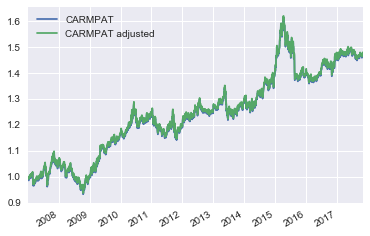

In [23]:
print("Auto-correlation of",fund_name,"returns :", alpha)
print("Auto-correlation of",fund_name,"adjusted returns :", beta)
ax = (1 + hrfx_returns).cumprod().plot()
_ = (1 + hrfx_returns_adj).cumprod()[fund_name].plot(label=fund_name + ' adjusted', legend=True, ax=ax)

## Estimation of the exposures

In [24]:
size = 126
freq = 5

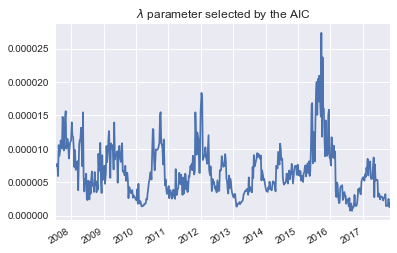

Wall time: 18.4 s


In [25]:
%%time
df_weight_aic, _ = lasso_regression_ic(hrfx_returns, returns_all,sample_length=size, frequency=freq, criterion='aic')
prices_for_track_aic = prices_all.loc[df_weight_aic.index[0]:]

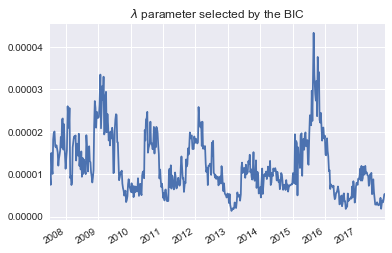

Wall time: 17.1 s


In [26]:
%%time
df_weight_bic, _ = lasso_regression_ic(hrfx_returns, returns_all,sample_length=size, frequency=freq, criterion='bic')
prices_for_track_bic = prices_all.loc[df_weight_bic.index[0]:]

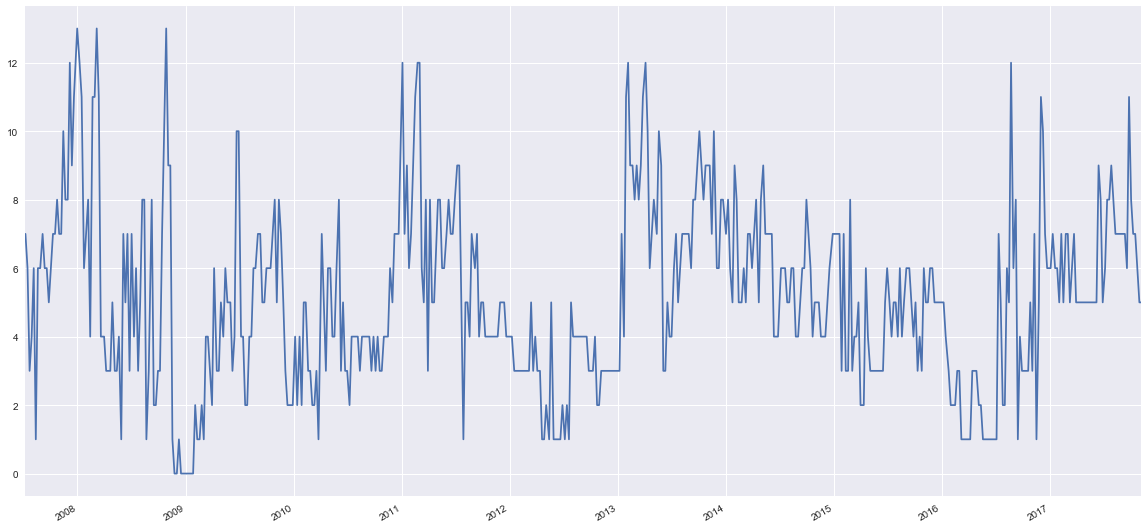

In [27]:
(df_weight_bic != 0).sum(axis=1).plot(figsize=(20,10))

In [28]:
%%time
nu = 1.0
df_weight_kalman = kalman_filter(hrfx_returns, returns_all,freq, sigma_weight=1. , sigma_return=nu)

prices_for_track_kalman = prices_all.loc[df_weight_kalman.index[0]:]

Wall time: 158 ms


In [29]:
%%time
tau = 0.1
freq_ml = 20
df_weight_ml_kalman, _ = ml_kalman_filter(hrfx_returns, returns_all, freq_ml, tau=tau)

Wall time: 4.77 s


In [30]:
%%time
df_weight_kalman_bic = selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='bic')

prices_for_track_kalman_bic = prices_all.loc[df_weight_kalman_bic.index[0]:]

Wall time: 18.9 s


In [31]:
%%time
df_weight_ml_kalman_bic = ml_selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq_ml,
                                                     tau=tau, criterion='bic')

prices_for_track_ml_kalman_bic = prices_all.loc[df_weight_ml_kalman_bic.index[0]:]

Wall time: 9.99 s


In [32]:
%%time
df_weight_kalman_aic = selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='aic')

prices_for_track_kalman_aic = prices_all.loc[df_weight_kalman_aic.index[0]:]

Wall time: 18.4 s


In [33]:
%%time
df_weight_ml_kalman_aic = ml_selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq_ml,
                                                     tau=tau, criterion='aic')

prices_for_track_ml_kalman_aic = prices_all.loc[df_weight_ml_kalman_aic.index[0]:]

Wall time: 6.88 s


## Replication

In [34]:
%%time
tc = 0.0005
lag = 3

replication_aic = make_track(prices_for_track_aic, df_weight_aic, tc=tc, lag=lag)
df_res = hfrx.loc[replication_aic.index]
df_res["Lasso AIC"] = replication_aic

replication_bic = make_track(prices_for_track_bic, df_weight_bic, tc=tc, lag=lag)
df_res["Lasso BIC"] = replication_bic

replication_kalman = make_track(prices_for_track_kalman, df_weight_kalman, tc=tc, lag=lag).loc[df_res.index[0]:]
df_res["Kalman"] = replication_kalman

replication_ml_kalman = make_track(prices_for_track_kalman, df_weight_ml_kalman, tc=tc, lag=lag).loc[df_res.index[0]:]
df_res["ML Kalman"] = replication_ml_kalman

replication_kalman_aic = make_track(prices_for_track_kalman_aic, df_weight_kalman_aic, tc=tc, lag=lag).loc[df_res.index[0]:]
df_res["Kalman AIC"] = replication_kalman_aic

replication_ml_kalman_aic = make_track(prices_for_track_ml_kalman_aic, df_weight_ml_kalman_aic, tc=tc, lag=lag).loc[df_res.index[0]:]
df_res["ML Kalman AIC"] = replication_ml_kalman_aic

replication_kalman_bic = make_track(prices_for_track_kalman_bic, df_weight_kalman_bic, tc=tc, lag=lag).loc[df_res.index[0]:]
df_res["Kalman BIC"] = replication_kalman_bic

replication_ml_kalman_bic = make_track(prices_for_track_ml_kalman_bic, df_weight_ml_kalman_bic, tc=tc, lag=lag).loc[df_res.index[0]:]
df_res["ML Kalman BIC"] = replication_ml_kalman_bic

Wall time: 62.3 ms


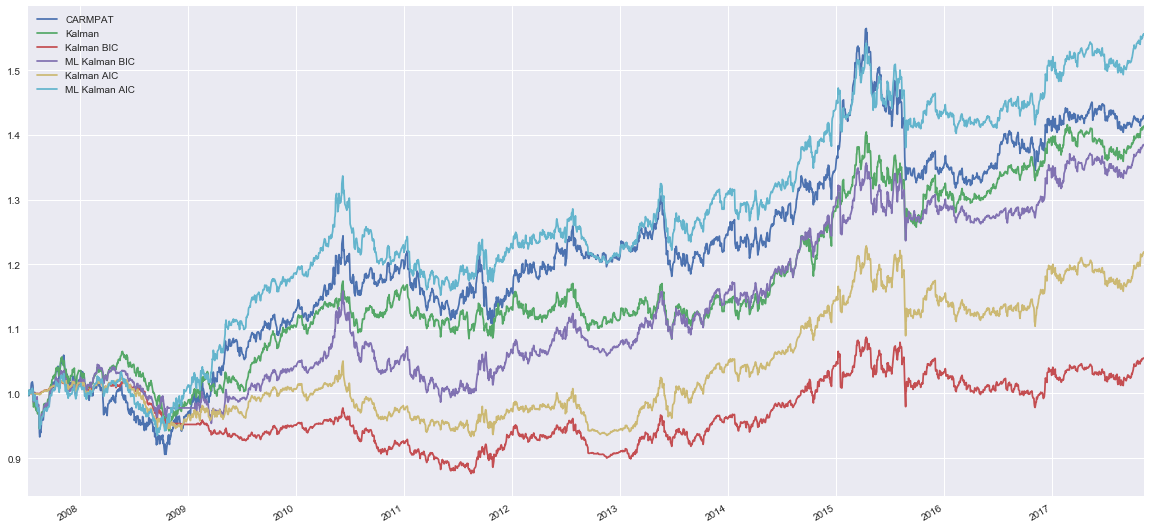

In [69]:
df_res = (df_res / df_res.iloc[0])
df_res[[fund_name, 'Kalman', 'Kalman BIC', "ML Kalman BIC", 'Kalman AIC', "ML Kalman AIC"]].plot(figsize=(20,10))

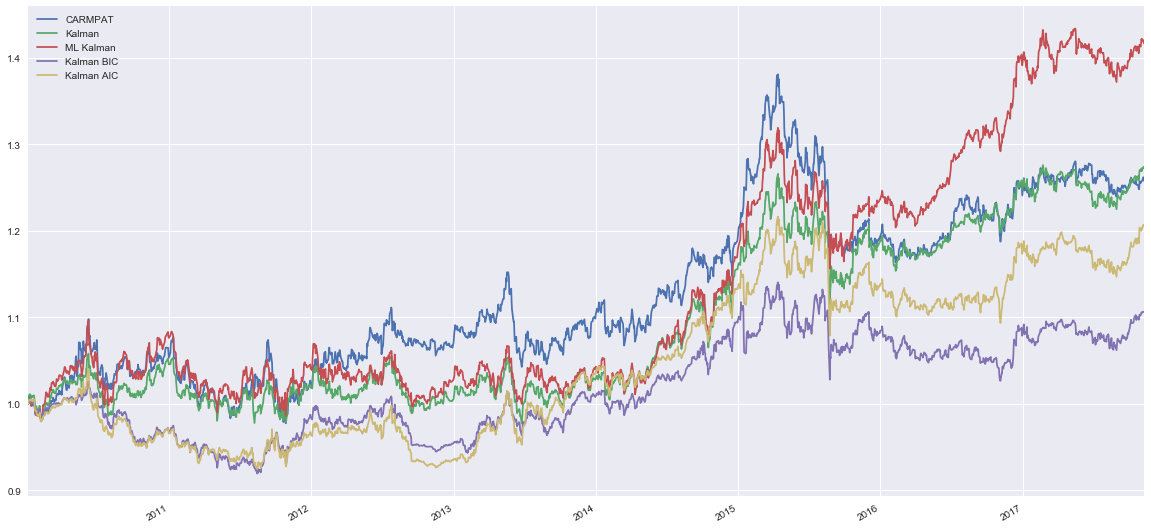

In [36]:
temp = df_res.loc['2010':]
temp = (temp / temp.iloc[0])
temp[[fund_name, 'Kalman', 'ML Kalman', 'Kalman BIC', 'Kalman AIC']].plot(figsize=(20,10))

In [37]:
df_stat = replication_stats(df_res, fund_name=fund_name)
df_stat

,Correlation,Kendall tau,Tracking error,R-squared,Sharpe ratio,Annual Return,Maximum Drawdown
CARMPAT,1.000000,1.000000,0.000000,1.000000,0.443394,0.181519,-0.154378
Lasso AIC,0.806247,0.606458,0.052136,0.634158,0.235009,0.060050,-0.150167
Lasso BIC,0.749828,0.546087,0.060224,0.511847,0.350217,0.074381,-0.113311
Kalman,0.803102,0.618252,0.051664,0.640754,0.483862,0.175265,-0.118936
ML Kalman,0.760217,0.571849,0.059066,0.530440,0.549425,0.229713,-0.123360
Kalman AIC,0.754854,0.564456,0.056539,0.569751,0.328486,0.096630,-0.113155
ML Kalman AIC,0.882269,0.708341,0.040579,0.778370,0.596201,0.229220,-0.132077
Kalman BIC,0.669071,0.501888,0.064066,0.447577,0.116957,0.025059,-0.143412
ML Kalman BIC,0.801607,0.611442,0.051628,0.641245,0.471239,0.164130,-0.142834


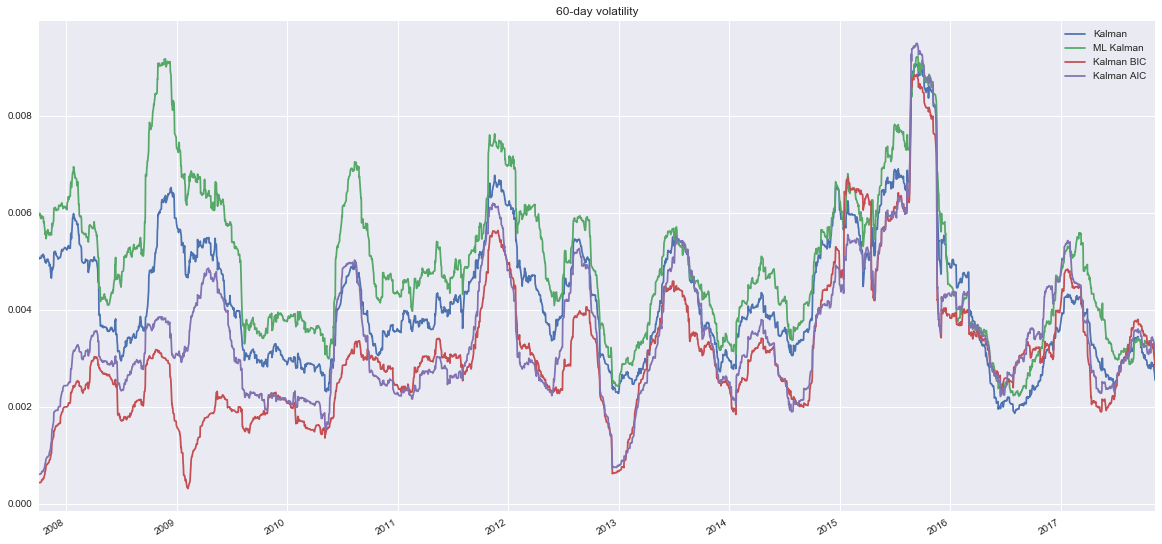

In [39]:
vol = df_res.pct_change().rolling(window=60).std().dropna()
(vol[['Kalman', 'ML Kalman', 'Kalman BIC', 'Kalman AIC']]).plot(figsize=(20,10), title='60-day volatility')

### Volatility adjustment

In [71]:
%%time
df_weight_kalman_aic_voladj = selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='aic', vol_target=True, vol_period=size)
df_weight_kalman_bic_voladj = selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='bic', vol_target=True, vol_period=size)
df_weight_kalman_voladj = kalman_filter(hrfx_returns, returns_all,freq, sigma_weight=1. , sigma_return=nu,
                                        vol_target=True, vol_period=size)
df_weight_ml_kalman_voladj, _ = ml_kalman_filter(hrfx_returns, returns_all,freq, tau=tau, vol_target=True, vol_period=size)

df_weight_kalman_aic_voladj_ml = ml_selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq_ml,\
                                          tau=tau, criterion='aic', vol_target=True, vol_period=size)

df_weight_kalman_bic_voladj_ml = ml_selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq_ml,\
                                          tau=tau, criterion='bic', vol_target=True, vol_period=size)


prices_for_track = prices_all.loc[df_weight_kalman_voladj.index[0]:]

replication_kalman_voladj = make_track(prices_for_track, df_weight_kalman_voladj, tc=tc, lag=lag)
df_res_voladj = hfrx.loc[replication_kalman_voladj.index]
df_res_voladj["Kalman"] = replication_kalman_voladj

replication_ml_kalman_voladj = make_track(prices_for_track, df_weight_ml_kalman_voladj, tc=tc, lag=lag)
df_res_voladj["ML Kalman"] = replication_ml_kalman_voladj

prices_for_track = prices_all.loc[df_weight_kalman_aic_voladj.index[0]:]

replication_kalman_bic_voladj = make_track(prices_for_track, df_weight_kalman_bic_voladj, tc=tc, lag=lag)
df_res_voladj["Kalman BIC"] = replication_kalman_bic_voladj

replication_kalman_aic_voladj = make_track(prices_for_track, df_weight_kalman_aic_voladj, tc=tc, lag=lag)
df_res_voladj["Kalman AIC"] = replication_kalman_aic_voladj

replication_kalman_bic_voladj_ml = make_track(prices_for_track, df_weight_kalman_bic_voladj_ml, tc=tc, lag=lag)
df_res_voladj["Kalman BIC ML"] = replication_kalman_bic_voladj_ml

replication_kalman_aic_voladj_ml = make_track(prices_for_track, df_weight_kalman_aic_voladj_ml, tc=tc, lag=lag)
df_res_voladj["Kalman AIC ML"] = replication_kalman_aic_voladj_ml

Wall time: 52.1 s


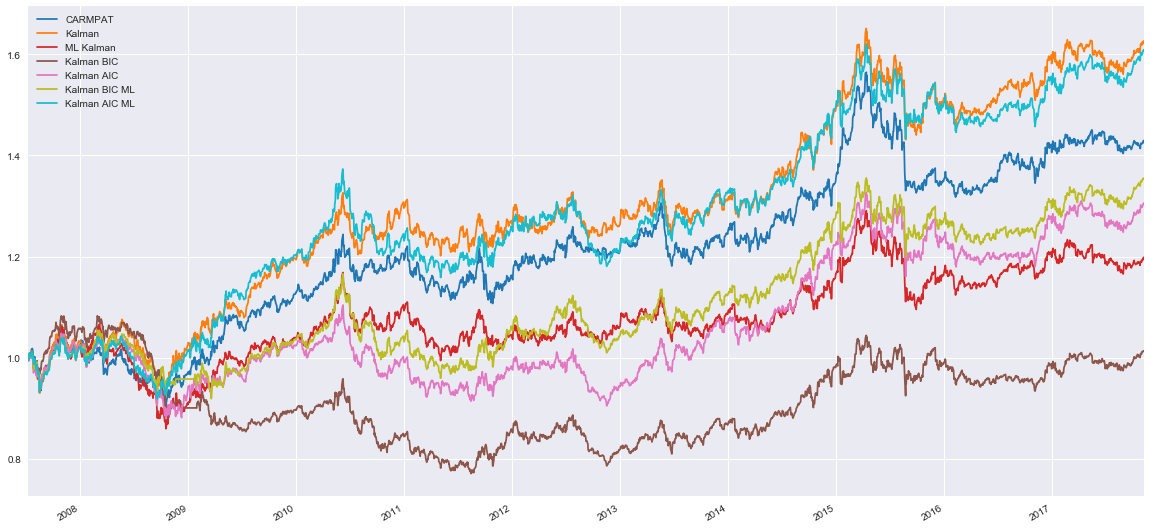

In [75]:
df_res_voladj = df_res_voladj.dropna()
df_res_voladj = (df_res_voladj / df_res_voladj.iloc[0])
df_res_voladj.plot(figsize=(20,10),cmap="tab10")

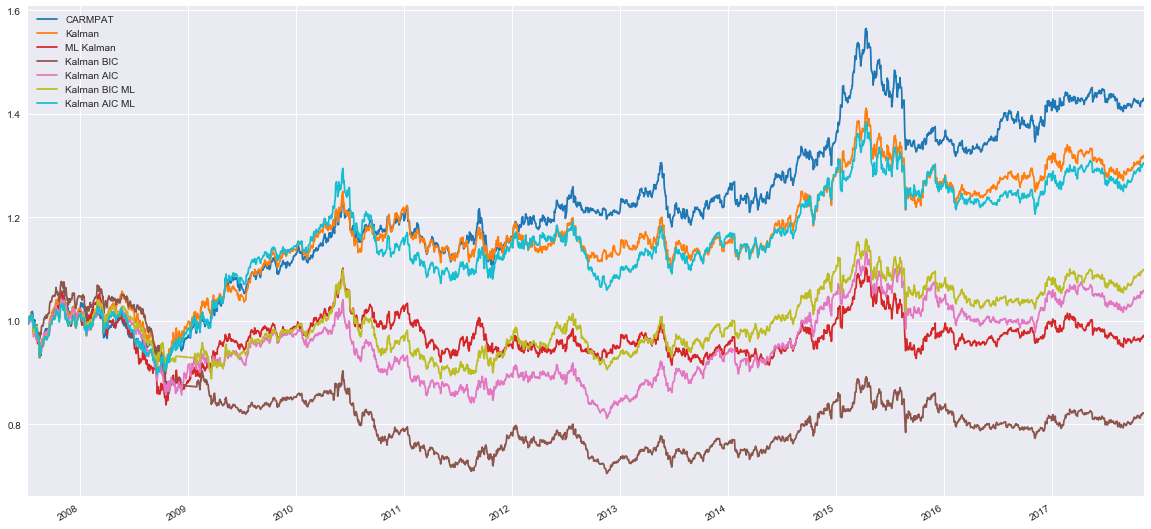

In [74]:
df_res_volperfadj = df_res_voladj[[fund_name]].copy()
temp = df_res_voladj.drop(fund_name, axis=1)
df_res_volperfadj[temp.columns]= make_ER(temp, 2 + 0 * US_rate)
df_res_volperfadj.plot(figsize=(20,10),cmap="tab10")

## Statistics on replication

In [76]:
df_stat_vol = replication_stats(df_res_voladj, fund_name=fund_name)
df_stat_vol

,Correlation,Kendall tau,Tracking error,R-squared,Sharpe ratio,Annual Return,Maximum Drawdown
CARMPAT,1.000000,1.000000,0.000000,1.000000,0.443394,0.181519,-0.154378
Kalman,0.853966,0.664655,0.047564,0.695505,0.569727,0.254832,-0.133240
ML Kalman,0.839826,0.683842,0.049639,0.668356,0.240856,0.088114,-0.176893
Kalman BIC,0.720336,0.525505,0.065016,0.431070,0.058496,0.006194,-0.288268
Kalman AIC,0.799796,0.588388,0.056008,0.577793,0.329928,0.132432,-0.173884
Kalman BIC ML,0.795545,0.599937,0.055660,0.583036,0.377902,0.152322,-0.170645
Kalman AIC ML,0.874710,0.696354,0.043806,0.741717,0.562699,0.248593,-0.149395


## Volatility contributions

In [77]:
df_vol_contrib_kalman_voladj = (prices_all.reindex(df_weight_kalman_voladj.index).pct_change()*df_weight_kalman_voladj).std()
df_vol_contrib_kalman_voladj = df_vol_contrib_kalman_voladj/df_vol_contrib_kalman_voladj.sum()

df_vol_contrib_kalman_bic_voladj = (prices_all.reindex(df_weight_kalman_bic_voladj.index).pct_change()*df_weight_kalman_bic_voladj).std()
df_vol_contrib_kalman_bic_voladj = df_vol_contrib_kalman_bic_voladj/df_vol_contrib_kalman_bic_voladj.sum()

df_vol_contrib_kalman_aic_voladj = (prices_all.reindex(df_weight_kalman_aic_voladj.index).pct_change()*df_weight_kalman_aic_voladj).std()
df_vol_contrib_kalman_aic_voladj = df_vol_contrib_kalman_aic_voladj/df_vol_contrib_kalman_aic_voladj.sum()

In [78]:
df_vol_contrib = pd.DataFrame()
df_vol_contrib["Kalman"] = df_vol_contrib_kalman_voladj
df_vol_contrib["Kalman BIC"] = df_vol_contrib_kalman_bic_voladj
df_vol_contrib["Kalman AIC"] = df_vol_contrib_kalman_aic_voladj
df_vol_contrib = df_vol_contrib.join(df_info).reset_index()

In [79]:
df_vol_contrib_asset_class = df_vol_contrib.drop(["Style"],axis=1).groupby(["Asset Class","index"]).sum()
df_vol_contrib_style = df_vol_contrib.drop(["Asset Class"],axis=1).groupby(["Style","index"]).sum()

In [80]:
g = hc_spiderweb(df_vol_contrib_asset_class, title="Vol contribution by Asset Class")
g.plot()

In [81]:
g = hc_spiderweb(df_vol_contrib_style, title="Vol contribution by Style")
g.plot()

In [82]:
g = hc_piechart(df_vol_contrib_asset_class[["Kalman BIC"]], title="Vol contribution by Asset Class in Kalman BIC")
g.plot()

In [83]:
g = hc_piechart(df_vol_contrib_style[["Kalman BIC"]], title="Vol contribution by Style in Kalman BIC")
g.plot()

## Performance contributions

In [102]:
df_perf_contrib_kalman_voladj = (1 + prices_all.reindex(df_weight_kalman_voladj.index).pct_change()*df_weight_kalman_voladj).prod() - 1

df_perf_contrib_kalman_bic_voladj = (1 + prices_all.reindex(df_weight_kalman_bic_voladj.index).pct_change()*df_weight_kalman_bic_voladj).prod() - 1

df_perf_contrib_kalman_aic_voladj_ml = (1 + prices_all.reindex(df_weight_kalman_aic_voladj_ml.index).pct_change()*df_weight_kalman_aic_voladj_ml).prod() - 1

In [103]:
df_perf_contrib = pd.DataFrame()
df_perf_contrib["Kalman"] = df_perf_contrib_kalman_voladj
df_perf_contrib["Kalman BIC"] = df_perf_contrib_kalman_bic_voladj
df_perf_contrib["Kalman AIC ML"] = df_perf_contrib_kalman_aic_voladj_ml
df_perf_contrib = df_perf_contrib.join(df_info).reset_index()

In [104]:
df_perf_contrib_asset_class = df_perf_contrib.drop(["Style"],axis=1).groupby(["Asset Class","index"]).sum()
df_perf_contrib_style = df_perf_contrib.drop(["Asset Class"],axis=1).groupby(["Style","index"]).sum()

In [105]:
g = hc_spiderweb(df_perf_contrib_asset_class, title="Vol contribution by Asset Class")
g.plot()

In [106]:
g = hc_spiderweb(df_perf_contrib_style, title="Vol contribution by Style")
g.plot()

## Average exposures

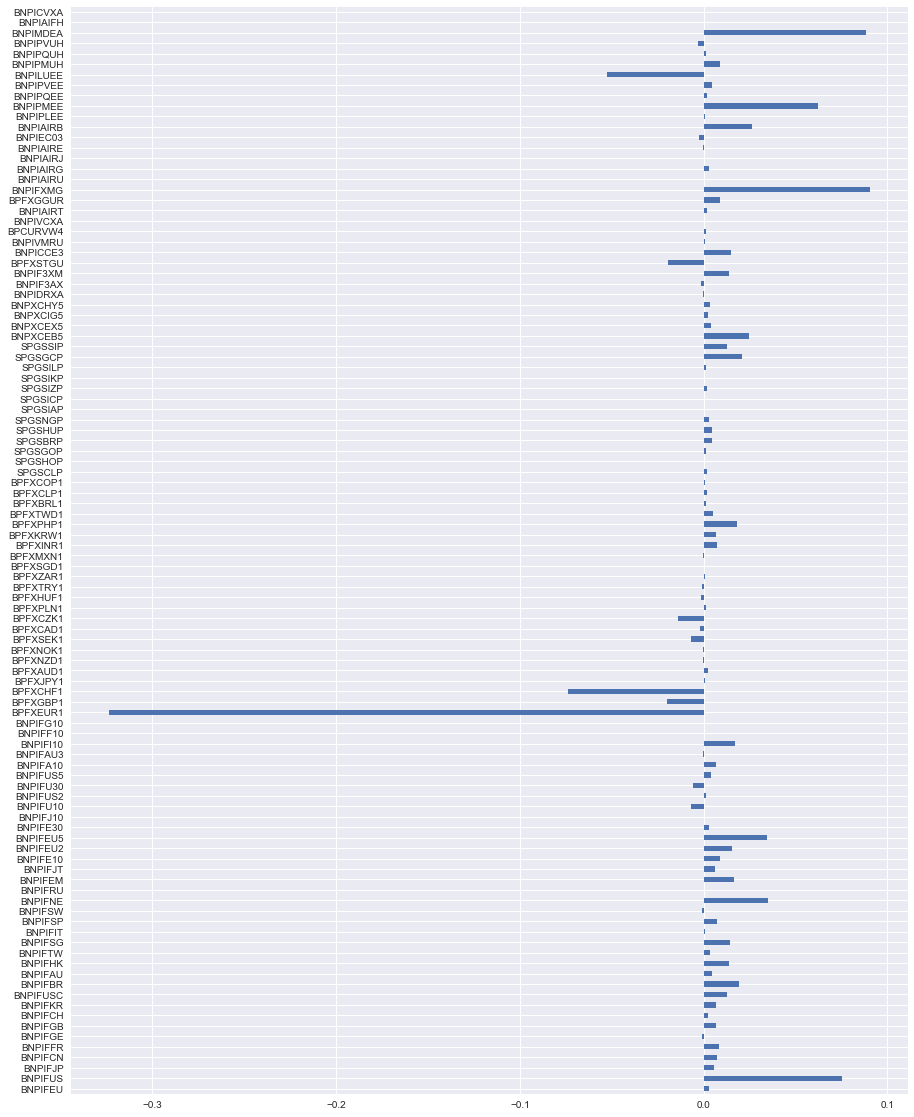

In [107]:
(df_weight_kalman_aic_voladj_ml).mean(axis=0).plot(kind='barh', figsize=(15,20))

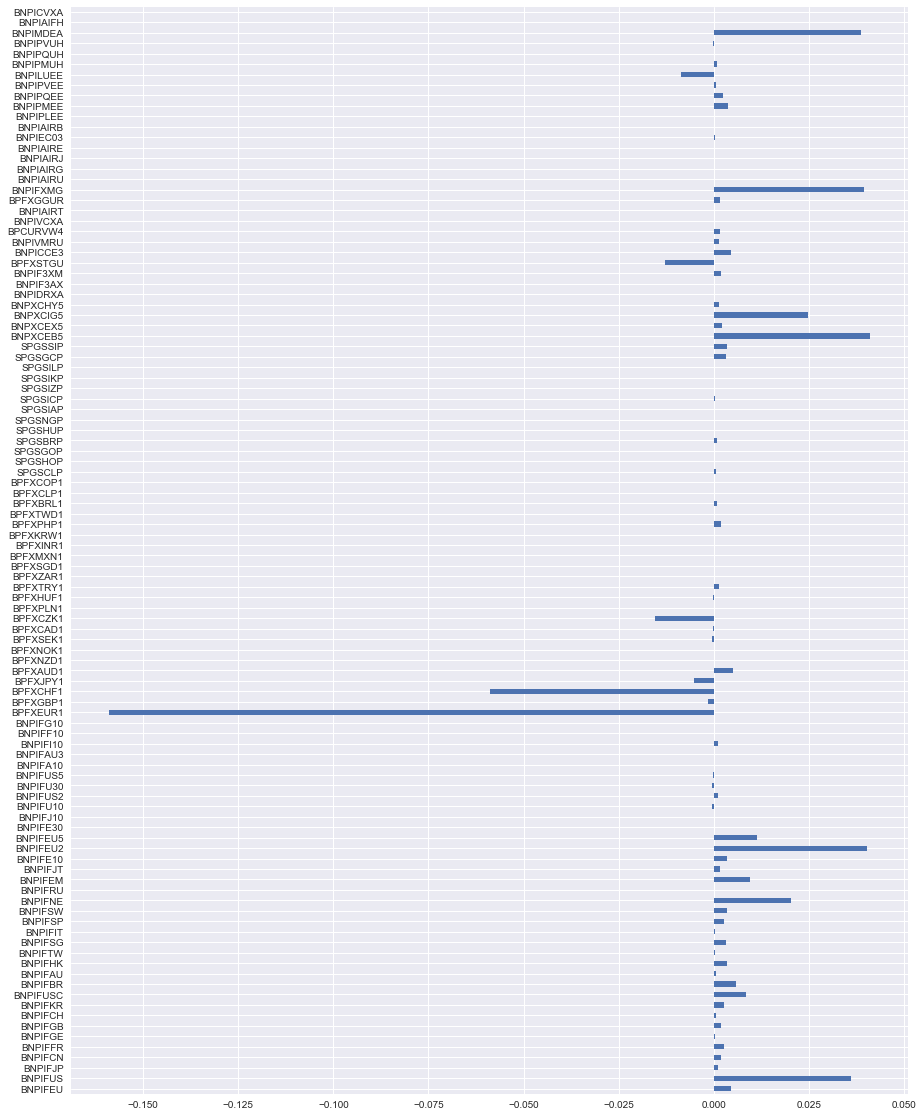

In [90]:
(df_weight_bic).mean(axis=0).plot(kind='barh', figsize=(15,20))

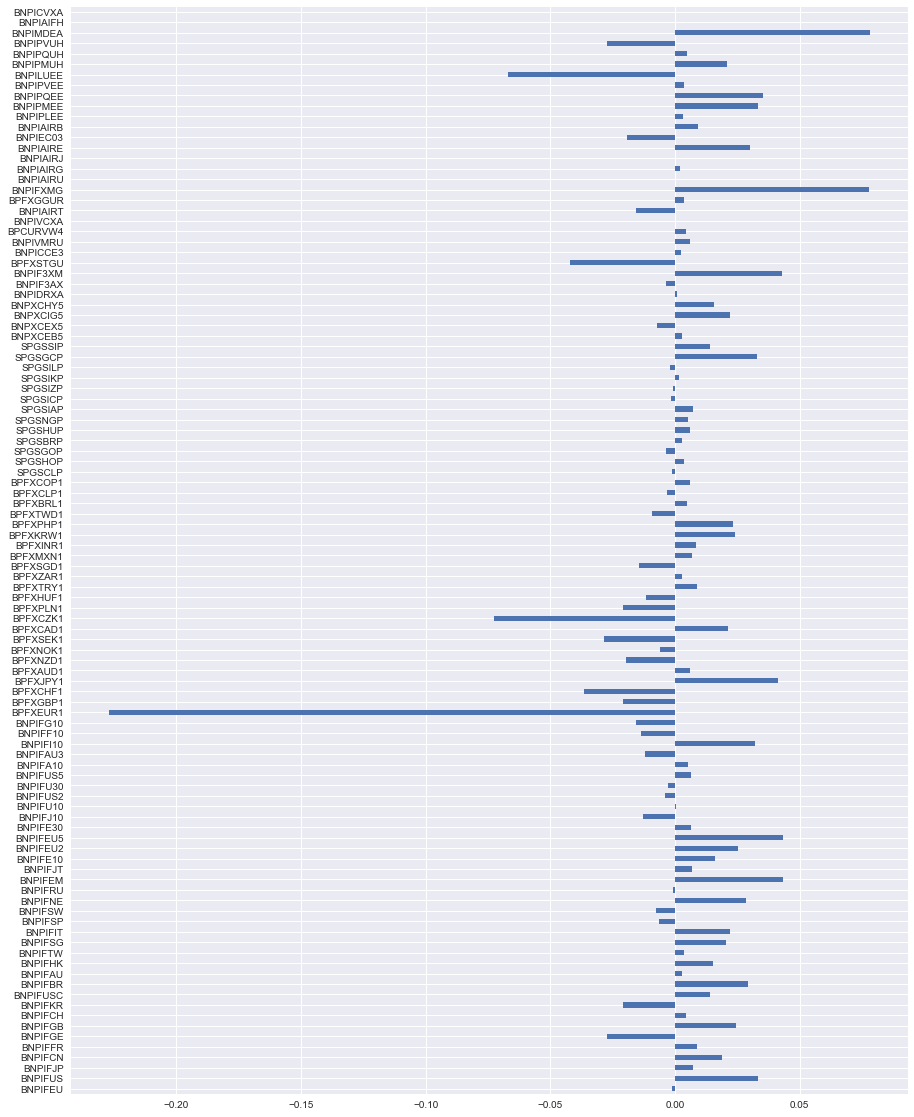

In [91]:
df_weight_kalman.loc[df_res.index[0]:].mean(axis=0).plot(kind='barh', figsize=(15,20))

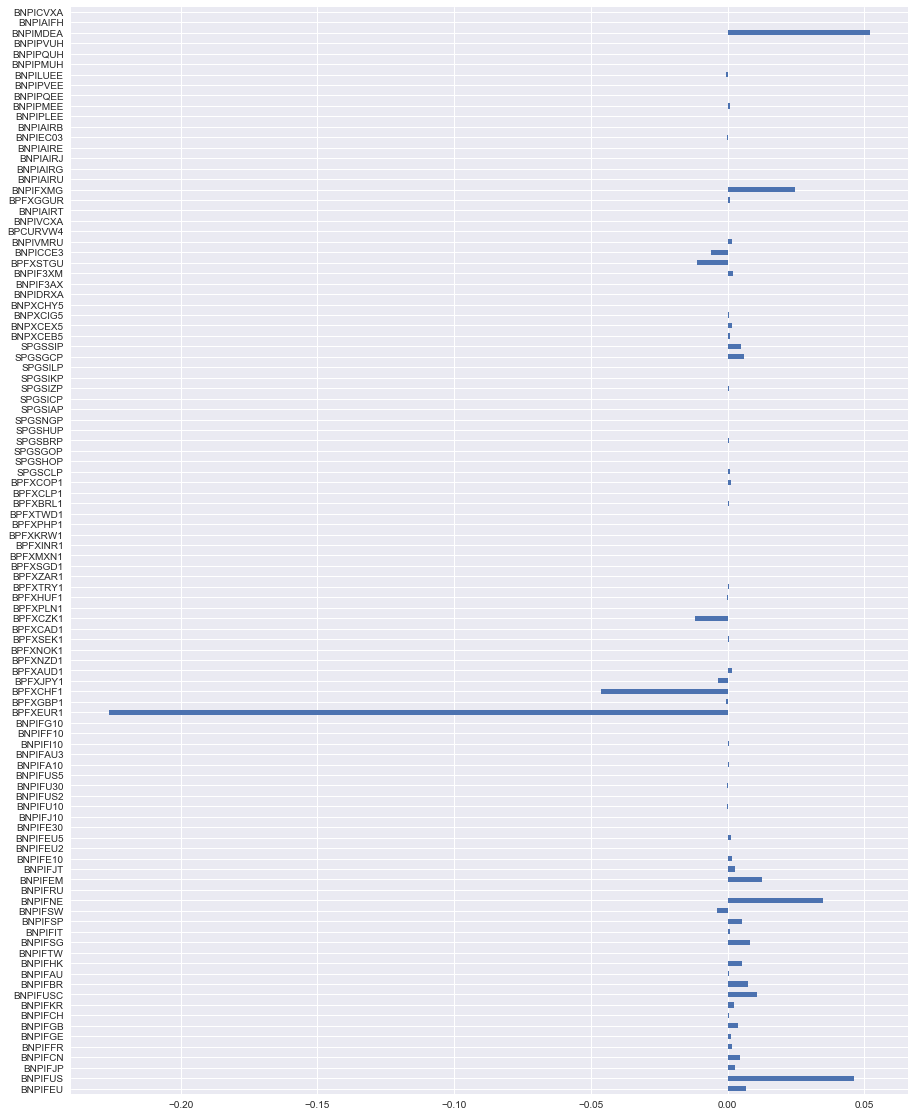

In [92]:
df_weight_kalman_bic.loc[df_res.index[0]:].mean(axis=0).plot(kind='barh', figsize=(15,20))

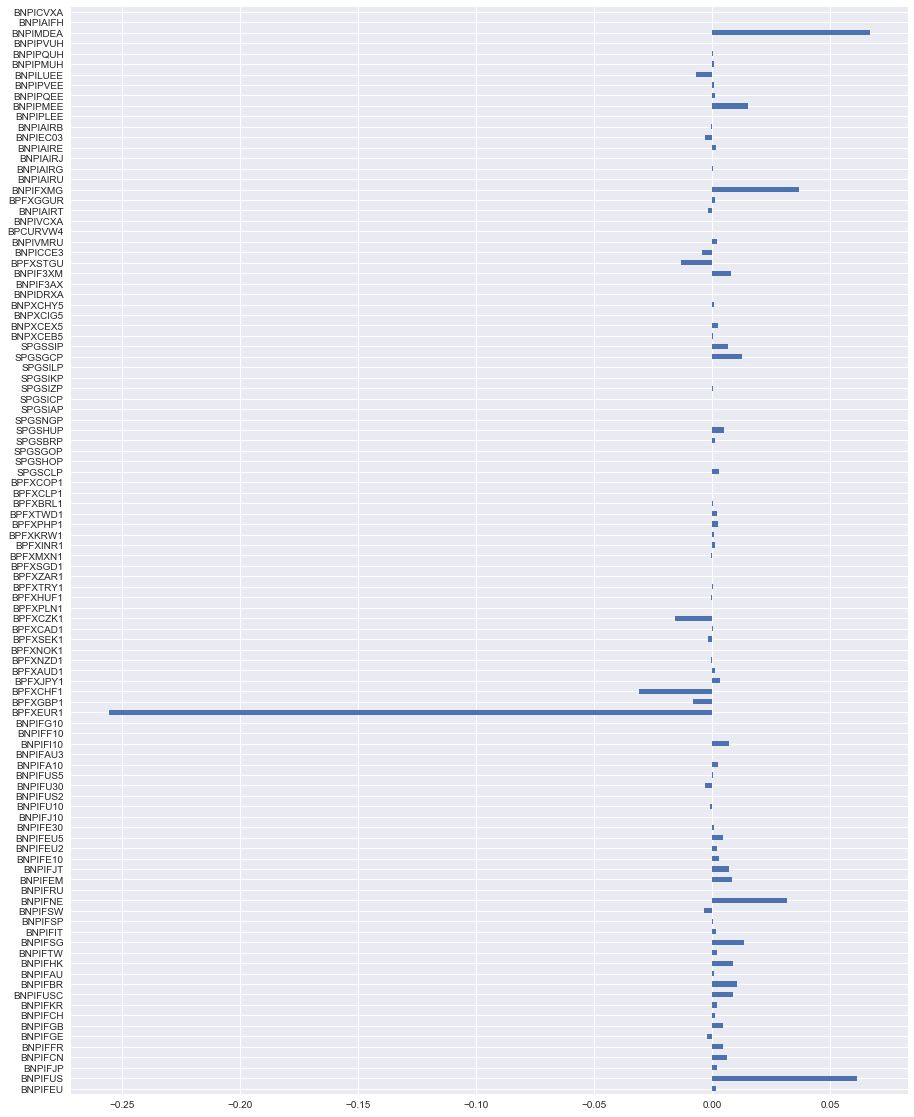

In [93]:
df_weight_kalman_aic.loc[df_res.index[0]:].mean(axis=0).plot(kind='barh', figsize=(15,20))

In [94]:
limit = 60
df_autocorr = pd.DataFrame(data=[df_res.drop(["Lasso AIC","Lasso BIC"],axis=1)\
                                 .pct_change().apply(lambda col : col.autocorr(lag=i)) for i in range(1,limit)])
df_autocorr[r"$2/\sqrt{n}$"] = [2/np.sqrt(len(df_res)-i) for i in range(1,limit)]
df_autocorr[r"$-2/\sqrt{n}$"] = [-2/np.sqrt(len(df_res)-i) for i in range(1,limit)]

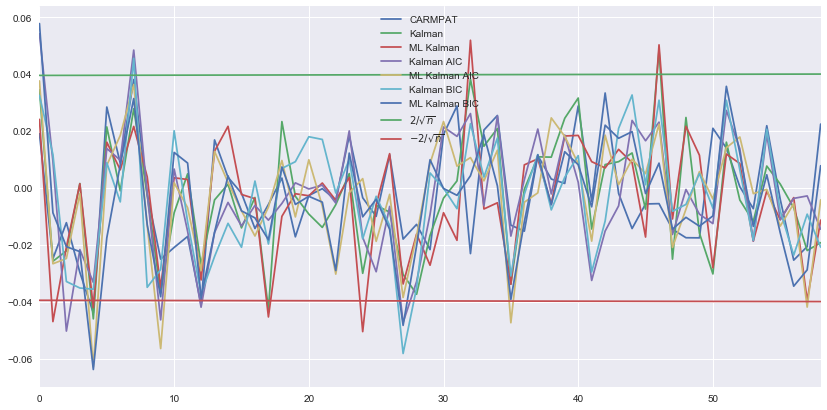

In [95]:
df_autocorr.plot(figsize=(14,7))

In [96]:
df_res[fund_name].pct_change().autocorr(lag=1)

0.019027504478720422

In [97]:
df_res['Kalman'].pct_change().autocorr(lag=1)

0.034485488101298818

In [98]:
df_res['Kalman BIC'].pct_change().autocorr(lag=1)

0.03249373181597958

In [99]:
df_res['Kalman AIC'].pct_change().autocorr(lag=1)

0.054141606741871212

In [100]:
df_res['Lasso AIC'].pct_change().autocorr(lag=1)

0.036656433888620693